## **Dataset**

In [1]:
!gdown 1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU
!unzip cvpr2016_flowers.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: content/cvpr2016_flowers/images/image_02041.jpg  
  inflating: content/cvpr2016_flowers/images/image_06550.jpg  
  inflating: content/cvpr2016_flowers/images/image_00556.jpg  
  inflating: content/cvpr2016_flowers/images/image_05695.jpg  
  inflating: content/cvpr2016_flowers/images/image_02732.jpg  
  inflating: content/cvpr2016_flowers/images/image_00112.jpg  
  inflating: content/cvpr2016_flowers/images/image_03424.jpg  
  inflating: content/cvpr2016_flowers/images/image_03702.jpg  
  inflating: content/cvpr2016_flowers/images/image_01316.jpg  
  inflating: content/cvpr2016_flowers/images/image_03391.jpg  
  inflating: content/cvpr2016_flowers/images/image_02503.jpg  
  inflating: content/cvpr2016_flowers/images/image_05044.jpg  
  inflating: content/cvpr2016_flowers/images/image_01633.jpg  
  inflating: content/cvpr2016_flowers/images/image_05305.jpg  
  inflating: content/cvpr2016_flowers/images/image_02522.jpg 

In [2]:
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_name = image_file.split('.')[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()
        if image_name not in captions:
                captions[image_name] = caption
    return captions

In [3]:
captions_folder = "./content/cvpr2016_flowers/captions"
image_folder = "./content/cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)

## **Caption Encoder**

In [4]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            'embed': torch.tensor(bert_model.encode(caption)),
            'text': caption
        }
    return encoded_captions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
encoded_captions = encode_captions(captions)

In [6]:
import matplotlib.pyplot as plt

def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## **Preprocess**

In [21]:
from PIL import Image
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load captions
        self.captions = captions

        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoded_caption = self.captions[img_name]['embed']
        caption = self.captions[img_name]['text']


        # Select a wrong image
        wrong_idx = np.random.choice([i for i in range(len(self.img_names)) if i != idx])
        wrong_img_name = self.img_names[wrong_idx]
        wrong_img_path = os.path.join(self.img_dir, wrong_img_name + ".jpg")
        wrong_image = Image.open(wrong_img_path).convert("RGB")

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return {
            "image": image,
            "caption": caption,
            "embed_caption": encoded_caption,
            "wrong_image": wrong_image
        }


In [22]:
import torchvision.transforms as transforms

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./content/cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

In [23]:
next(iter(ds))

{'image': tensor([[[ 0.4196,  0.3804,  0.3333,  ..., -0.7333, -0.7333, -0.7176],
          [ 0.4824,  0.4510,  0.3882,  ..., -0.8588, -0.8588, -0.8431],
          [ 0.5373,  0.5137,  0.4588,  ..., -0.8667, -0.8745, -0.8510],
          ...,
          [ 0.4980,  0.4902,  0.4902,  ..., -0.0745, -0.0745, -0.0588],
          [ 0.4745,  0.4745,  0.4745,  ..., -0.1294, -0.1294, -0.1059],
          [ 0.4431,  0.4431,  0.4431,  ..., -0.1216, -0.0980, -0.0824]],
 
         [[ 0.6627,  0.6471,  0.6314,  ..., -0.1608, -0.1765, -0.1686],
          [ 0.7020,  0.6941,  0.6627,  ..., -0.1843, -0.2000, -0.1922],
          [ 0.7333,  0.7333,  0.7020,  ..., -0.1529, -0.1843, -0.1843],
          ...,
          [ 0.7647,  0.7647,  0.7647,  ...,  0.4824,  0.4745,  0.4824],
          [ 0.7412,  0.7412,  0.7490,  ...,  0.4824,  0.4745,  0.4824],
          [ 0.7020,  0.7020,  0.7020,  ...,  0.4667,  0.4902,  0.4980]],
 
         [[-0.1059, -0.1216, -0.1216,  ..., -0.5843, -0.5686, -0.5608],
          [-0.0588,

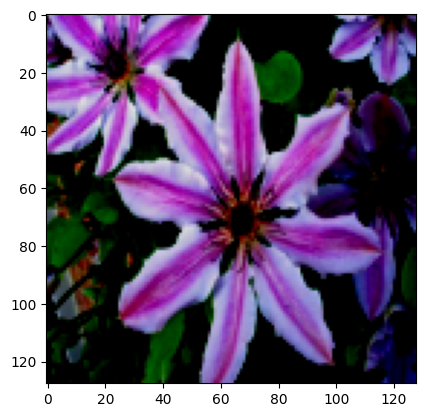

In [24]:
show_grid(next(iter(ds))['wrong_image'])

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
batch_sample = next(iter(dataloader))

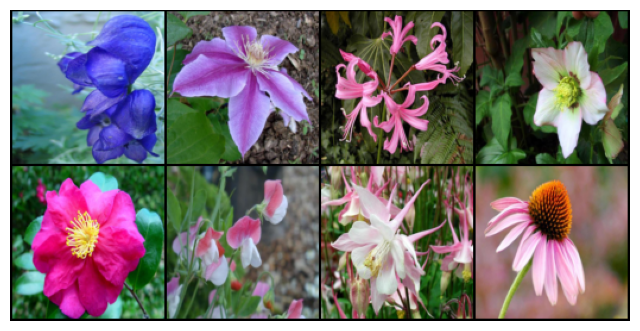

In [33]:
import torchvision
import matplotlib.pyplot as plt

images = batch_sample['image'][:8]

# Tạo lưới ảnh
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)  # 4 ảnh mỗi hàng

# Hàm hiển thị
def show_grid(img_tensor):
    plt.figure(figsize=(8,8))
    npimg = img_tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Gọi hàm hiển thị
show_grid(grid)


## **Model**

In [34]:
import torch.nn as nn

class Generator(nn.Module):

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        #768-->256
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.upsamplingBlock = nn.Sequential(
            #256+100 --> 1024
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # 1024 --> 512
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # 512 --> 256
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # 256 --> 128
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # 128 --> 128
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # 128 --> 3
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.upsamplingBlock(concat_input)
        return output

In [35]:
generator = Generator(100, 128, 3, 768, 256).to(device)

In [36]:
class Discriminator(nn.Module):

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.imageEncoder = nn.Sequential(
            # 3 -> 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # 128 -> 128
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # 128 -> 256
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # 256 -> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 -> 1024
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, input_img, text_embeddings):
        image_encoded = self.imageEncoder(input_img)

        text_encoded = self.textEncoder(text_embeddings)

        replicated_text = text_encoded.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        concat_layer = torch.cat([image_encoded, replicated_text], 1)

        x = self.finalBlock(concat_layer)

        return x.view(-1, 1), image_encoded

In [37]:
discriminator = Discriminator(3, 128, 768, 256).to(device)

## **Training**

In [38]:
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [39]:
plt_o_text_embeddings = ds[0]['embed_caption'].unsqueeze(0)
plt_o_text_embeddings.shape

torch.Size([1, 768])

In [40]:
fixed_noise = torch.randn(size=(1, 100))
fixed_noise.shape

torch.Size([1, 100])

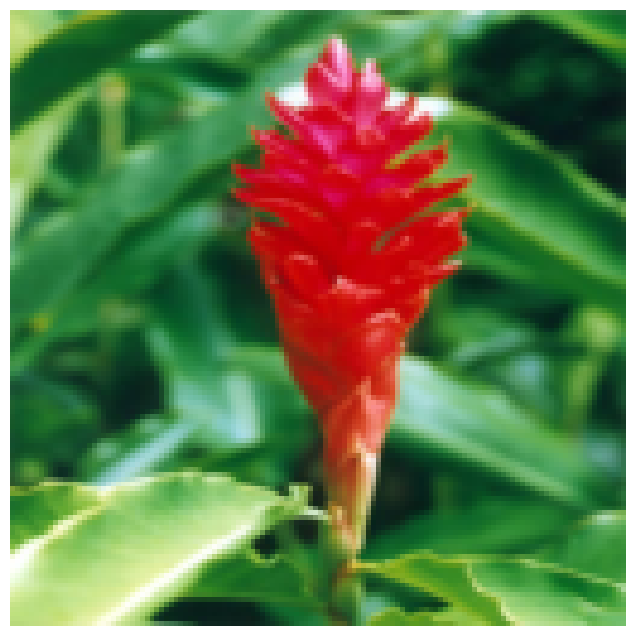

In [41]:
import torchvision

show_grid(torchvision.utils.make_grid(ds[0]['image'], normalize=True))

In [42]:
def plot_output(generator):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [43]:
import torch.optim as optim

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [1/50] loss_D: 1.5069 loss_G: 2.7002 time: 154.97
Epoch [2/50] loss_D: 1.2097 loss_G: 2.2866 time: 157.91
Epoch [3/50] loss_D: 1.2197 loss_G: 2.2116 time: 157.42
Epoch [4/50] loss_D: 1.2403 loss_G: 2.1477 time: 156.53
Epoch [5/50] loss_D: 1.2478 loss_G: 2.0804 time: 156.53
Epoch [6/50] loss_D: 1.2262 loss_G: 2.0608 time: 157.03
Epoch [7/50] loss_D: 1.3224 loss_G: 2.0070 time: 157.60
Epoch [8/50] loss_D: 1.2477 loss_G: 1.8575 time: 157.20
Epoch [9/50] loss_D: 1.2900 loss_G: 1.8935 time: 157.70


<Figure size 640x480 with 0 Axes>

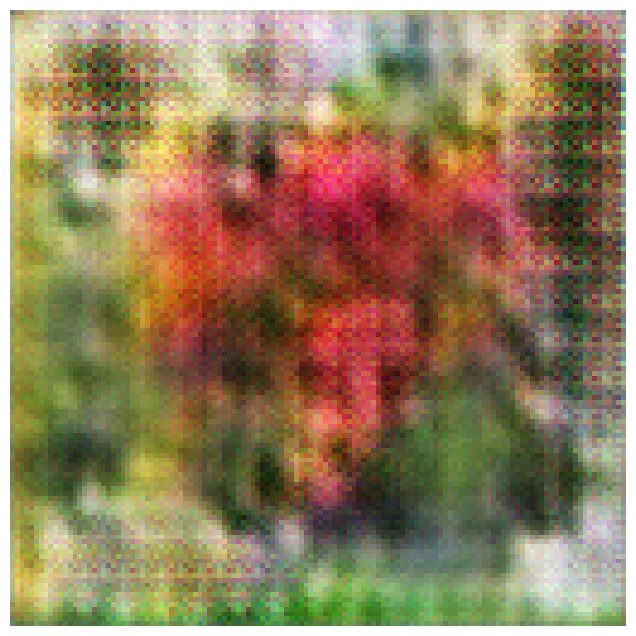

Epoch [10/50] loss_D: 1.2782 loss_G: 1.9261 time: 157.50
Epoch [11/50] loss_D: 1.2847 loss_G: 1.9125 time: 157.33
Epoch [12/50] loss_D: 1.2738 loss_G: 1.8585 time: 155.72
Epoch [13/50] loss_D: 1.2841 loss_G: 1.8851 time: 156.87
Epoch [14/50] loss_D: 1.2635 loss_G: 1.9577 time: 156.98
Epoch [15/50] loss_D: 1.2816 loss_G: 1.9097 time: 157.97
Epoch [16/50] loss_D: 1.2615 loss_G: 1.8726 time: 157.62
Epoch [17/50] loss_D: 1.2744 loss_G: 1.9149 time: 157.97
Epoch [18/50] loss_D: 1.3163 loss_G: 1.8934 time: 156.52
Epoch [19/50] loss_D: 1.2671 loss_G: 1.8590 time: 158.11


<Figure size 640x480 with 0 Axes>

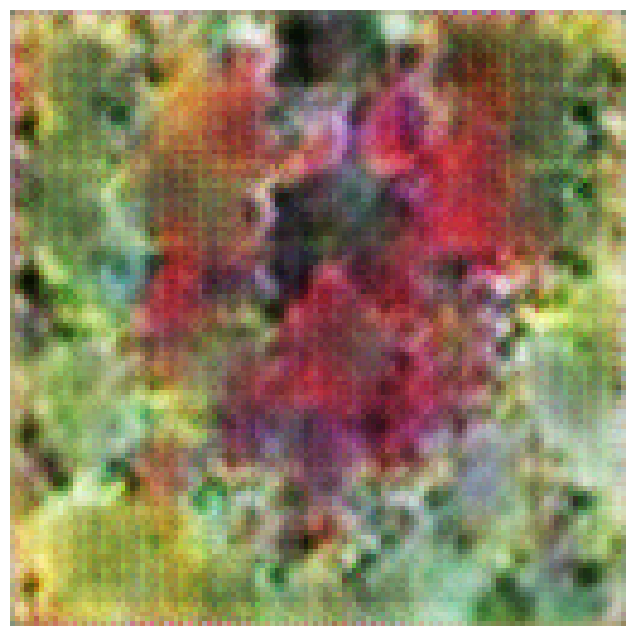

Epoch [20/50] loss_D: 1.2575 loss_G: 1.9207 time: 156.76
Epoch [21/50] loss_D: 1.2571 loss_G: 1.9249 time: 156.88
Epoch [22/50] loss_D: 1.2427 loss_G: 1.9647 time: 157.11
Epoch [23/50] loss_D: 1.2740 loss_G: 1.9603 time: 156.15
Epoch [24/50] loss_D: 1.2255 loss_G: 1.9619 time: 156.64
Epoch [25/50] loss_D: 1.2053 loss_G: 2.0499 time: 158.89
Epoch [26/50] loss_D: 1.2823 loss_G: 1.8973 time: 156.57
Epoch [27/50] loss_D: 1.2469 loss_G: 1.9322 time: 156.76
Epoch [28/50] loss_D: 1.2219 loss_G: 1.9719 time: 156.67
Epoch [29/50] loss_D: 1.2259 loss_G: 1.9668 time: 156.70


<Figure size 640x480 with 0 Axes>

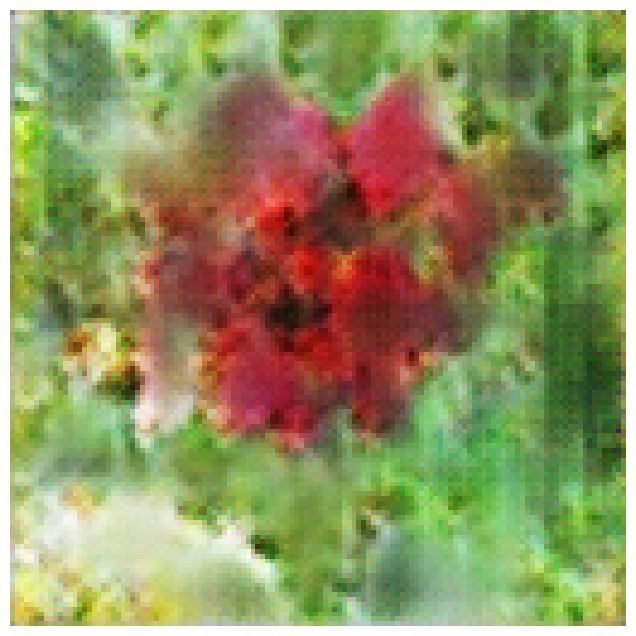

Epoch [30/50] loss_D: 1.2741 loss_G: 1.9741 time: 157.14
Epoch [31/50] loss_D: 1.2521 loss_G: 1.9604 time: 157.32
Epoch [32/50] loss_D: 1.2382 loss_G: 1.9388 time: 156.74
Epoch [33/50] loss_D: 1.2340 loss_G: 1.9738 time: 159.62
Epoch [34/50] loss_D: 1.2220 loss_G: 1.9838 time: 154.21
Epoch [35/50] loss_D: 1.2432 loss_G: 1.9185 time: 156.09
Epoch [36/50] loss_D: 1.2332 loss_G: 1.9560 time: 154.92
Epoch [37/50] loss_D: 1.2018 loss_G: 1.9855 time: 156.16
Epoch [38/50] loss_D: 1.2303 loss_G: 1.9415 time: 154.50
Epoch [39/50] loss_D: 1.2285 loss_G: 1.9296 time: 157.32


<Figure size 640x480 with 0 Axes>

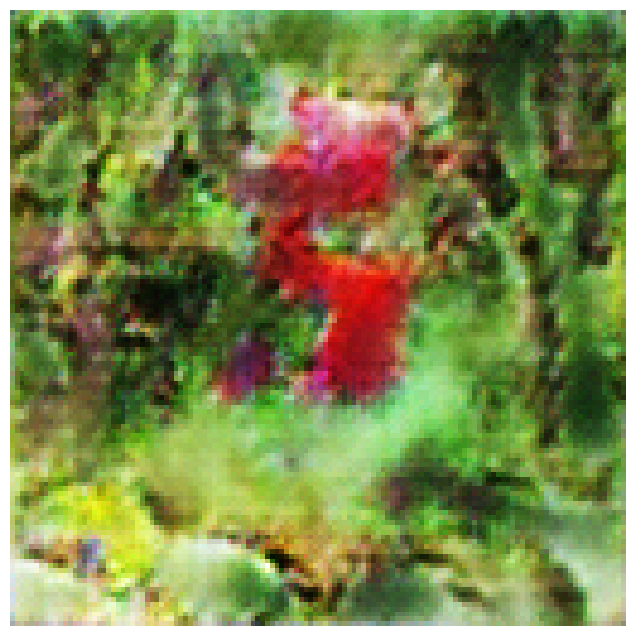

Epoch [40/50] loss_D: 1.1947 loss_G: 1.9728 time: 155.43
Epoch [41/50] loss_D: 1.2349 loss_G: 1.8900 time: 155.99
Epoch [42/50] loss_D: 1.2287 loss_G: 1.9578 time: 156.39
Epoch [43/50] loss_D: 1.2149 loss_G: 1.9542 time: 156.06
Epoch [44/50] loss_D: 1.2662 loss_G: 1.9168 time: 155.50
Epoch [45/50] loss_D: 1.2186 loss_G: 1.9135 time: 156.43
Epoch [46/50] loss_D: 1.2014 loss_G: 2.0127 time: 154.72
Epoch [47/50] loss_D: 1.2126 loss_G: 2.0097 time: 156.55
Epoch [48/50] loss_D: 1.1602 loss_G: 2.1870 time: 154.79
Epoch [49/50] loss_D: 1.1292 loss_G: 2.2469 time: 156.97


<Figure size 640x480 with 0 Axes>

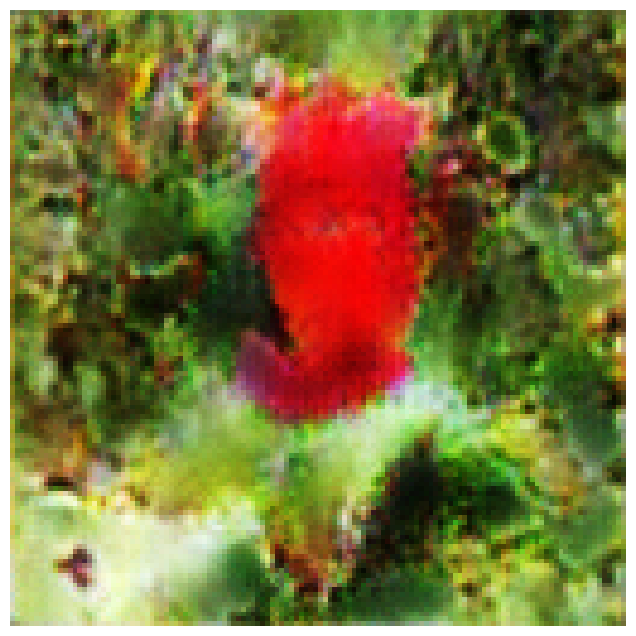

Epoch [50/50] loss_D: 1.2261 loss_G: 1.9989 time: 154.69


In [44]:
import time

epochs = 50

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in dataloader:
        images = batch['image'].to(device)  # Đưa ảnh lên GPU
        embed_captions = batch['embed_caption'].to(device)  # Đưa captions lên GPU (đã là tensor)
        wrong_images = batch['wrong_image'].to(device)  # Đưa ảnh lên GPU

        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        # Training the discriminator
        optimizer_D.zero_grad()

        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        outputs, _ = discriminator(images, embed_captions)
        real_loss = bce_loss(outputs, real_labels)

        outputs, _ = discriminator(wrong_images, embed_captions)
        wrong_loss = bce_loss(outputs, fake_labels)

        outputs, _ = discriminator(fake_images.detach(), embed_captions)
        fake_loss = bce_loss(outputs, fake_labels)
        d_loss = real_loss + fake_loss + wrong_loss

        d_loss.backward()
        optimizer_D.step()

        tg_loss = real_loss.item() + fake_loss.item()

        d_losses.append(tg_loss)

        # Training generator
        optimizer_G.zero_grad()
        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        outputs, fake_features = discriminator(fake_images, embed_captions)
        _, real_features = discriminator(images, embed_captions)

        activation_fake = torch.mean(fake_features, 0)
        activation_real = torch.mean(real_features, 0)

        real_loss = bce_loss(outputs, real_labels)

        g_loss = real_loss + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, images)

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(real_loss.item())

    avg_d_loss = sum(d_losses)/len(d_losses)
    avg_g_loss = sum(g_losses)/len(g_losses)

    if (epoch+1) % 10 == 0:
        plot_output(generator)

    print('Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, epochs,
        avg_d_loss,
        avg_g_loss,
        time.time() - epoch_time)
    )

In [51]:
import torch

# Save generator
torch.save(generator.state_dict(), 'generator.pth')

# Save discriminator
torch.save(discriminator.state_dict(), 'discriminator.pth')

Caption: this flower has purple petals, deep purple anther and filament, and white stigma.


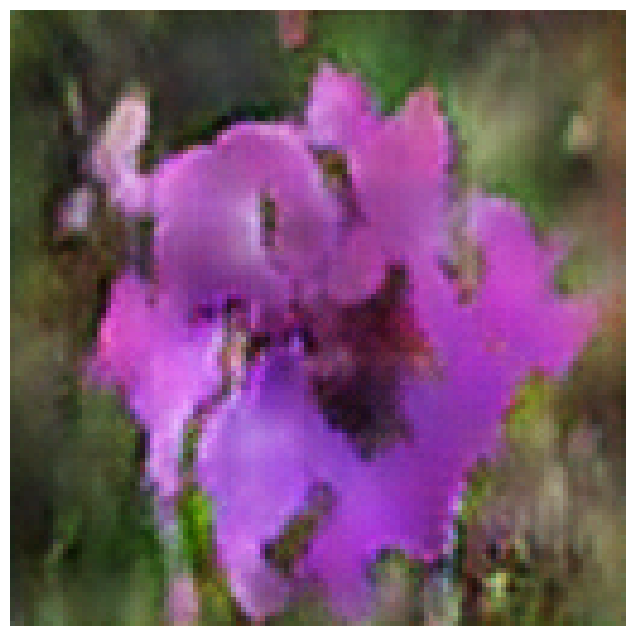

In [47]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = ds[10]["embed_caption"].unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))

grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)

print(f"Caption: {ds[10]['caption']}")
show_grid(grid)